# Creating Dataloaders using `torch-em`

The tutorial is focused on creating dataloaders using `torch-em` for various segmentation tasks. Let's get started.
The first thing to do would be to make sure that we have `torch-em` installed and accessible in the kernel. 

In [4]:
_found_torch_em = False

URL = "https://github.com/constantinpape/torch-em#installation"

try:
    import torch_em
    print("Yayy, we found 'torch-em'. Start creating your dataloaders already. Skip to Step 0.")
    _found_torch_em = True
except ModuleNotFoundError:
    print(f"'torch-em' was not found. Please install it from {URL}")

Yayy, we found 'torch-em'. Start creating your dataloaders already. Skip to Step 0.


If the script above suggests to install `torch-em`, we need to install all the relevant [packages](https://github.com/constantinpape/torch-em?tab=readme-ov-file#installation)

Let's check where are you now?

In [35]:
# overwrite for the online notebooks you are using
using_colab = False
using_kaggle = False

In [36]:
import os
current_spot = os.getcwd()

resource_status = (using_colab + using_kaggle)
assert resource_status <= 1, "Oops, you can't be on both Kaggle and Colab at the same time, please choose one!"

if current_spot.startswith("/content") or using_colab:
    using_colab = True
    print("Google Colab says hi!")
elif current_spot.startswith("/kaggle/working") or using_kaggle:
    using_kaggle = True
    print("Kaggle Notebook says hi!")
else:
    if _found_torch_em:
        print("You have 'torch-em' installed already.")
    else:
        print("You are using a behind-the-scenes resource. Follow our installation instructions here.")

You have 'torch-em' installed already.


In [37]:
# Now that we are aware of our setup, let's carefully install 'torch-em'
# TODO: test this on Kaggle / Colab
if not _found_torch_em:
    !git clone https://github.com/constantinpape/torch-em
    !pip install ${current_spot}/torch-em

Ideally, this should not throw any errors. If there are some modules missing, please go ahead and install them.

## Step 0: Let's explore our datasets

We will follow the process of creating dataloaders from two different open-source datasets (already supported by torch-em), and learn how to create dataloaders (for an unsupported dataset as well in the end) for training a UNet architecture. The choice of datasets are following:

1. DSB (Nuclei Segmentation in Light Microscopy: Caicedo et al. - https://doi.org/10.1038/s41592-019-0612-7)
2. PlantSeg (Cell Segmentation in Confocal and Light-Sheet Microscopy: Wolny et al. - https://doi.org/10.7554/eLife.57613)

In [141]:
def _fetch_datasets(dataset_name, path, download=True):
    if dataset_name == "dsb":
        from torch_em.data.datasets.dsb import _download_dsb
        _download_dsb(path, "reduced", download=download)
        data_path = path

    elif dataset_name == "plantseg_root":
        # let's test for root
        from torch_em.data.datasets.plantseg import _require_plantseg_data
        data_path = _require_plantseg_data(path, download=download, name="root", split="train")

    elif dataset_name == "TODO":
        raise NotImplementedError

    else:
        raise ValueError(f"Oops, download is not enabled for {dataset_name}.")

    return data_path

from matplotlib import colors
import numpy as np

# TODO: add this in torch-em, it's a good function to have
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap


def plot_samples(image, labels, cmap="gray", view_napari=False):
    _found_napari = False
    try:
        import napari
        _found_napari = True
    except ModuleNotFoundError:
        assert (using_colab + using_kaggle) == 0, "napari does not work on Kaggle / Colab."
        print("Please install 'napari' if you are using local resources and want to visualize using napari.")

    def _get_mpl_plots(image, labels):
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image, cmap=cmap)
        ax[0].axis("off")
        ax[0].set_title("Image")

        ax[1].imshow(labels, cmap=get_random_colors(labels), interpolation="nearest")
        ax[1].axis("off")
        ax[1].set_title("Labels")
        plt.show()

    if view_napari:
        if _found_napari:
            v = napari.Viewer()
            v.add_image(image)
            v.add_labels(labels)
            napari.run()
        else:
            print("Couldn't spot 'napari' to visualize the image, please make 'view_napari' to False and visualize the images in matplotlib.")
    else:
        _get_mpl_plots(image, labels)

Our dataset is downloaded. Let's explore them quickly before proceeding to create the dataset object.

In [142]:
DATA_DIR = "/media/anwai/ANWAI/data/"

dsb_path = _fetch_datasets(dataset_name="dsb", path=os.path.join(DATA_DIR, "dsb"), download=False)
plantseg_root_path = _fetch_datasets(dataset_name="plantseg_root", path=os.path.join(DATA_DIR, "plantseg_root"), download=False)

The image extension seems to be: ('/media/anwai/ANWAI/data/dsb/train/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', '.tif')
The label extension seems to be: ('/media/anwai/ANWAI/data/dsb/train/masks/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', '.tif')


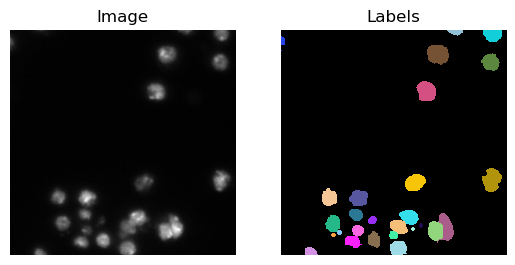

In [143]:
# For DSB
image_paths = sorted(glob(os.path.join(dsb_path, "train", "images", "*.tif")))
label_paths = sorted(glob(os.path.join(dsb_path, "train", "masks", "*.tif")))

import imageio.v3 as imageio

print("The image extension seems to be:", os.path.splitext(image_paths[0]))
print("The label extension seems to be:", os.path.splitext(label_paths[0]))

# It appears that the images are in tif format. It's a supported data format. Now let's check the data structure.

image_shapes = [imageio.imread(path).shape for path in image_paths]
label_shapes = [imageio.imread(path).shape for path in label_paths]

# It appears that the images has one channel. It's a supported data structure as well. Now let's visualize one image to understand our data better.
for image_path, label_path in zip(image_paths, label_paths):
    image = imageio.imread(image_path)
    labels = imageio.imread(label_path)

    plot_samples(image, labels)

    break  # it's enough to check a few samples, feel free to explore the entire dataset

In [144]:
# For PlantSeg
volume_paths = glob(os.path.join(plantseg_root_path, "*"))

print("The volume extension seems to be:", os.path.splitext(volume_paths[0]))

# It appears that the images are in hdf5 format.

# Let's try to open one image first
import h5py

with h5py.File(volume_paths[0]) as f:
    image = f["raw"][:]
    label = f["label"][:]

    print("The image volume and label volume respectively are:", image.shape, label.shape)

    plot_samples(image, label, view_napari=True)

The volume extension seems to be: ('/media/anwai/ANWAI/data/plantseg_root/root_train/Movie1_t00009_crop_gt', '.h5')
The image volume and label volume respectively are: (200, 550, 1000) (200, 550, 1000)


## Step 1: Let's create the dataset

In [152]:
# DSB dataset
# We observe that all the inputs are one-channel tif images, and their labels are instance segmentation.
# Now, let's create a dataset to for semantic nuclei labels

from torch_em import default_segmentation_dataset
from torch_em.transform.label import labels_to_binary

patch_shape = (256, 256)
file_description = "*.tif"

dsb_dataset = default_segmentation_dataset(
    raw_paths=os.path.join(dsb_path, "train", "images"),
    raw_key=file_description,
    label_paths=os.path.join(dsb_path, "train", "masks"),
    label_key=file_description,
    patch_shape=patch_shape,
    label_transform=labels_to_binary,  # remember the discussion above for semantic nuclei labels?
    ndim=2
)

In [154]:
# PlantSeg dataset
# We observe that all the inputs are volume images, with a different number if slices in each stack
# Now, let's create a dataset for boundary labels

from torch_em.transform.label import BoundaryTransform

patch_shape = (1, 512, 512)

volume_paths = glob(os.path.join(plantseg_root_path, "*.h5"))

plantseg_root_dataset = default_segmentation_dataset(
    raw_paths=volume_paths,
    raw_key="raw",
    label_paths=volume_paths,
    label_key="label",
    patch_shape=patch_shape,
    label_transform=BoundaryTransform(),
    ndim=2,
    
)

## Step 2: Let's create the dataloader

In [155]:
# DSB dataloader

from torch_em import get_data_loader

dsb_loader = get_data_loader(dsb_dataset, batch_size=2)


In [156]:
# PlantSeg dataloader

plantseg_root_loader = get_data_loader(plantseg_root_dataset, batch_size=2)

## Step 3: Let's check our dataloaders

In [166]:
def look_at_chosen_loader(chosen_loader, do_run=False):
    if do_run:
        save_path = f"./loader.png"
        print("Let's check how the samples look first. We store the images here:", save_path)
        from torch_em.util.debug import check_loader
        check_loader(chosen_loader, 8, plt=True)
    else:
        print(f"There are {len(chosen_loader)} samples generated from the loader. Please pass 'do_run=True' to 'look_at_chosen_loader' function for visualizing the samples.")
        return

    for x, y in chosen_loader:
        print("For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape")
        break  # checking out the shape of one sample is enough

Let's check how the samples look first. We store the images here: ./loader.png


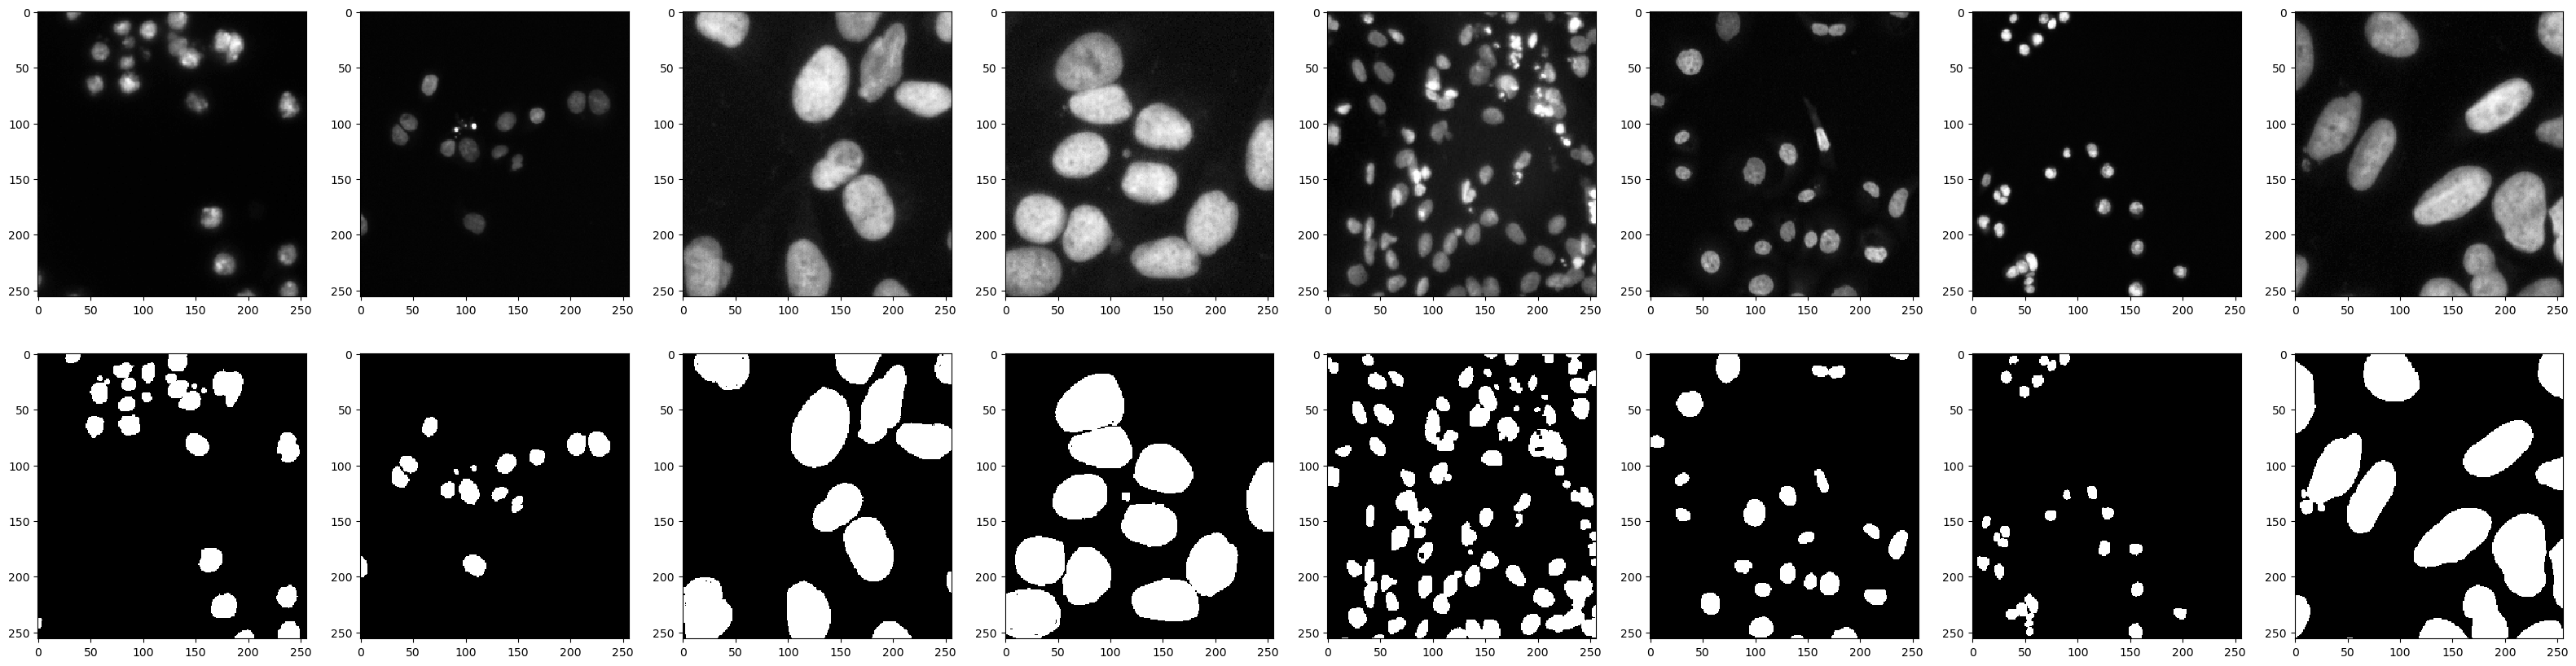

For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape


In [167]:
# Visualize DSB dataloader
look_at_chosen_loader(dsb_loader, do_run=True)

Let's check how the samples look first. We store the images here: ./loader.png


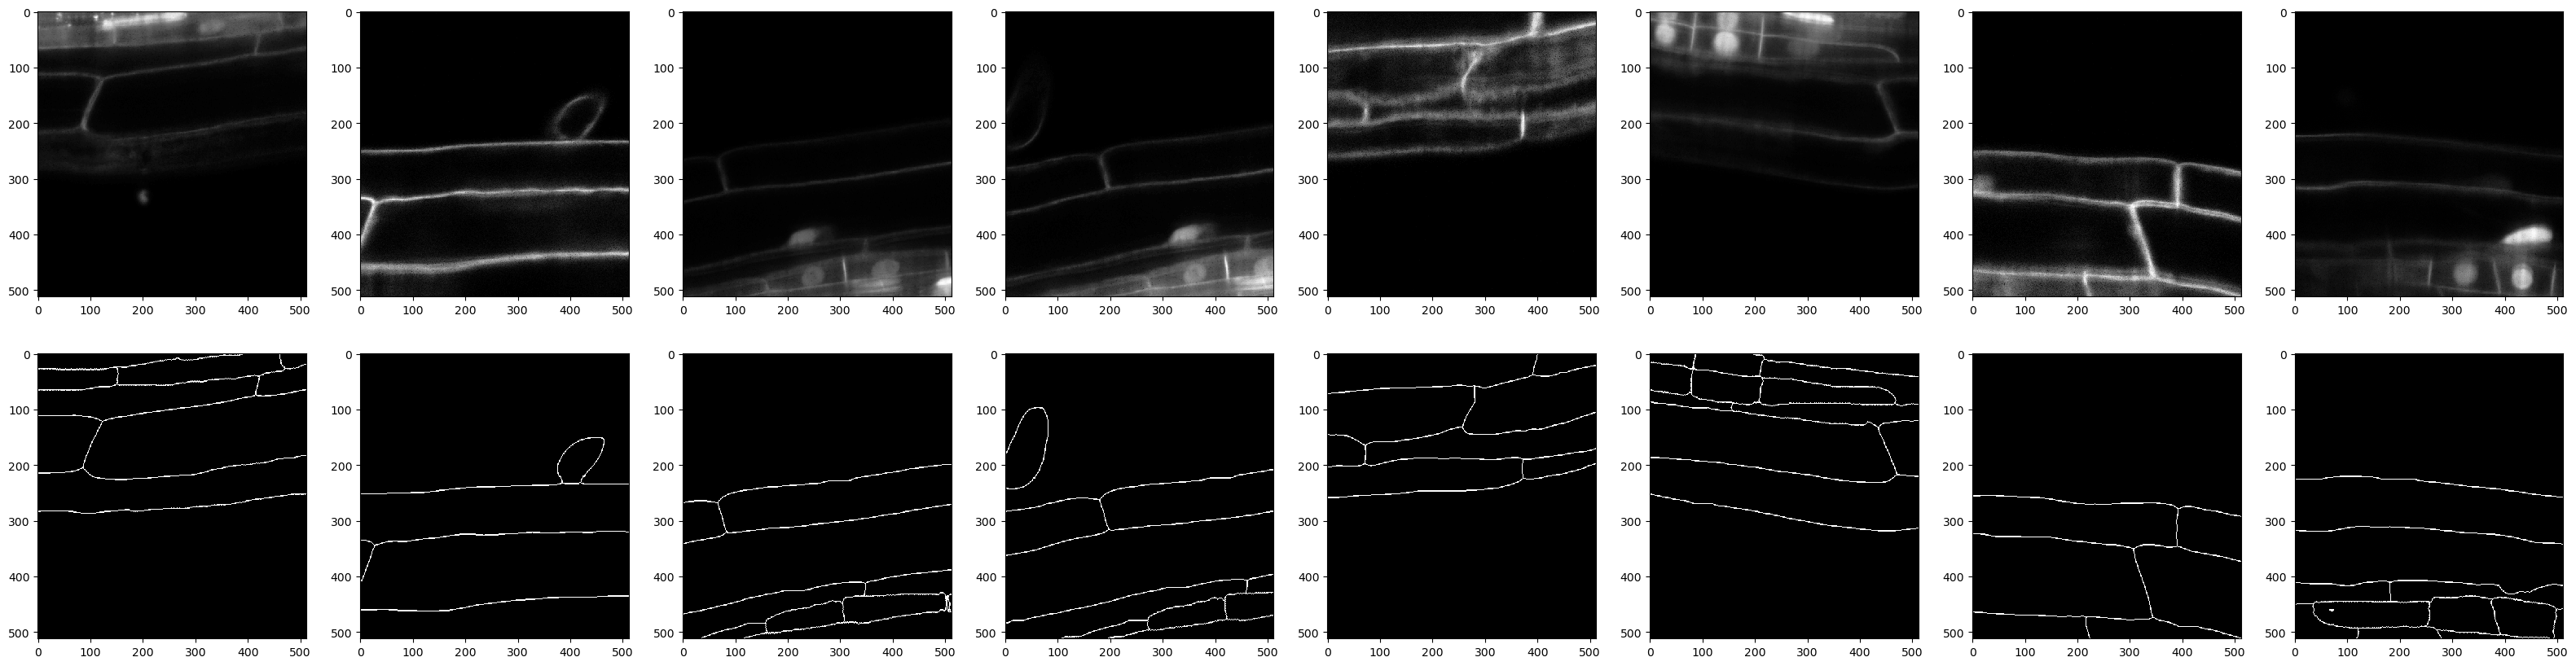

For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape


In [169]:
# Visualize PlantSeg (Root) dataloader
look_at_chosen_loader(plantseg_root_loader, do_run=True)